In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Gerando dados sintéticos
np.random.seed(42)
n_samples = 200
potencia = np.random.uniform(100, 300, n_samples)
peso = np.random.uniform(1000, 2500, n_samples)
consumo = 20 - 0.05 * potencia + 0.01 * peso + 0.0001 * potencia * peso + np.random.normal(0, 1, n_samples)

df = pd.DataFrame({'potencia': potencia, 'peso': peso, 'consumo': consumo})

new_example = pd.DataFrame({'potencia': [2000], 'peso': [150], 'consumo': [20 - 0.05 * 200 + 0.01 * 1500 + 0.0001 * 200 * 1500 + np.random.normal(0, 1)]})
df = pd.concat([df, new_example], ignore_index=True)

df.head()

,potencia,peso,consumo
0,174.908024,1963.047469,66.525828
1,290.142861,1126.209947,49.452138
2,246.398788,1242.443071,51.400091
3,219.731697,2347.831283,83.770756
4,131.203728,1909.643589,57.915652


In [20]:
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('consumo')  # Remover a variável alvo

def remove_outliers(df, columns, z_threshold):
    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        df = df[z_scores < z_threshold]
    return df

print ("\nTamanho do DataFrame antes da remoção de outliers:")
print(df.shape)

# Quanto MAIOR o valor de z_threshold, MENOS outliers serão removidos
z_threshold = 3
df = remove_outliers(df, numeric_columns, z_threshold)

print("\nTamanho do DataFrame após remoção de outliers:")
print(df.shape)


Tamanho do DataFrame antes da remoção de outliers:
(201, 3)

Tamanho do DataFrame após remoção de outliers:
(200, 3)


Coeficientes (Equação Normal com Poly): [ 6.26070313e+01  7.36966183e+00  1.36105959e+01 -1.28528824e+00
  1.95265924e+00 -1.47259558e+00 -1.60786312e-01  1.14128311e-01
 -4.84571562e-02 -7.82525265e-01  9.99405118e-01  5.51988448e-01
  9.62486587e-01  3.89841698e-02  1.11758468e+00  1.11419520e-01
  1.33118966e-02 -8.60265055e-02 -1.46609863e-02  8.49560751e-02
  2.47034236e-01 -2.97871256e-01 -1.63207787e-01 -7.96183991e-02
 -6.00025398e-02 -2.39922634e-01  1.18417595e-01 -2.42249925e-01]
Previsões para os dados de teste (Equação Normal): [63.96904427 45.05628412 79.07943252 72.10885624 45.63813738 82.7914358
 61.52353406 47.30390545 45.3651362  88.14670461 60.62992169 80.37657125
 64.43872619 67.44776286 58.46042623 39.80283783 66.63060229 59.38138608
 53.21607258 46.58908677 72.16645696 50.47712464 46.2720249  57.69648119
 74.6547847  65.00798825 61.24782935 80.88749278 70.99343818 37.25205982
 50.64775894 67.6685202  76.12077823 68.37270459 72.70966898 85.56754466
 40.00260405 77.

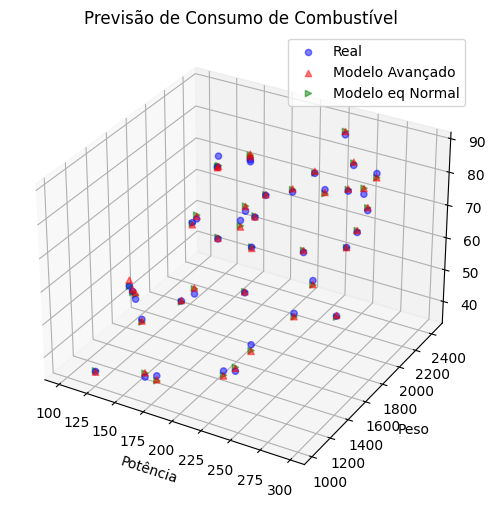


Interpretação do Modelo Equação Normal:
Intercepto: 62.6070
potencia: 7.3697
peso: 13.6106
potencia^2: -1.2853
potencia peso: 1.9527
peso^2: -1.4726

Interpretação do Modelo Avançado (Sklearn):
Coeficiente de potencia: 7.3444
Coeficiente de peso: 13.1681
Coeficiente de potencia^2: -0.1497
Coeficiente de potencia peso: 2.6718
Coeficiente de peso^2: 0.0278
O modelo avançado captura interações entre as variáveis e efeitos não-lineares.


In [12]:
#--------------------------------------- Divisão dos dados em treino e teste ---------------------------------------#
X = df[['potencia', 'peso']]
y = df['consumo']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#--------------------------------------- Modelagem Equação Normal ---------------------------------------#

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Gerando os termos polinomiais
poly_features = PolynomialFeatures(degree=6, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train_scaled)

# Adicionando o bias (termo de intercepto)
X_train_poly_eq = np.c_[np.ones(X_train_poly.shape[0]), X_train_poly]

# Aplicando a equação normal
theta_eq_poly = np.linalg.inv(X_train_poly_eq.T @ X_train_poly_eq) @ X_train_poly_eq.T @ y_train

print("Coeficientes (Equação Normal com Poly):", theta_eq_poly)

# Padronizando os dados de teste usando o scaler treinado
X_test_scaled = scaler.transform(X_test)

# Gerando os termos polinomiais para os dados de teste
X_test_poly = poly_features.transform(X_test_scaled)

# Adicionando o bias (termo de intercepto) aos dados de teste
X_test_poly_eq = np.c_[np.ones(X_test_poly.shape[0]), X_test_poly]

# Fazendo previsões usando o vetor de coeficientes obtido pela equação normal
y_pred_linear = X_test_poly_eq @ theta_eq_poly

# Exibindo as previsões
print("Previsões para os dados de teste (Equação Normal):", y_pred_linear)

#--------------------------------------- Modelagem Sklearn ---------------------------------------#

# Modelo Avançado: Regressão com interações e transformações
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), ['potencia', 'peso'])]
)

poly_features = PolynomialFeatures(degree=2, include_bias=False)

model_advanced = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', poly_features),
    ('regressor', LinearRegression())
])

model_advanced.fit(X_train, y_train)

print("Coeficientes (Sklearn):", model_advanced.named_steps['regressor'].coef_)

#--------------------------------------- Avaliação dos modelos ---------------------------------------#

# Avaliação dos modelos
y_pred_advanced = model_advanced.predict(X_test)

# Avaliando a performance dos dois modelos
print("\nMSE (Equação Normal):", mean_squared_error(y_test, y_pred_linear))
print("R2 (Equação Normal):", r2_score(y_test, y_pred_linear))
print("MSE (Avançado):", mean_squared_error(y_test, y_pred_advanced))
print("R2 (Avançado):", r2_score(y_test, y_pred_advanced))

#--------------------------------------- Visualização e interpretação dos modelos ---------------------------------------#

# Visualização 3D das previsões
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_test['potencia'], X_test['peso'], y_test, c='blue', marker='o', alpha=0.5, label='Real')
ax.scatter(X_test['potencia'], X_test['peso'], y_pred_advanced, c='red', marker='^', alpha=0.5, label='Modelo Avançado')
ax.scatter(X_test['potencia'], X_test['peso'], y_pred_linear, c='green', marker='>', alpha=0.5, label='Modelo eq Normal')

ax.set_xlabel('Potência')
ax.set_ylabel('Peso')
ax.set_zlabel('Consumo')
ax.set_title('Previsão de Consumo de Combustível')
plt.legend()
plt.show()

#--------------------------------------- Interpretação dos modelos ---------------------------------------#

# Interpretação do Modelo Linear (Equação Normal)
print("\nInterpretação do Modelo Equação Normal:")
feature_names = ['Intercepto'] + poly_features.get_feature_names_out(['potencia', 'peso']).tolist()
for name, coef in zip(feature_names, theta_eq_poly):
    print(f"{name}: {coef:.4f}")

# Interpretação do Modelo Avançado (Sklearn)
print("\nInterpretação do Modelo Avançado (Sklearn):")
feature_names_advanced = poly_features.get_feature_names_out(['potencia', 'peso'])
coefficients_advanced = model_advanced.named_steps['regressor'].coef_
for name, coef in zip(feature_names_advanced, coefficients_advanced):
    print(f"Coeficiente de {name}: {coef:.4f}")

print("O modelo avançado captura interações entre as variáveis e efeitos não-lineares.")
